In [1]:
from __future__ import absolute_import, print_function, unicode_literals
import sys
import os
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import analysis as a
from IPython.display import display, HTML
sys.path.append('/home/janekg89/Develop/Pycharm_Projects/flutype_webapp')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "flutype_webapp.settings")
import django
django.setup()
from flutype.models import Spot

****************************************
RUNNING IN DEVELOP
****************************************


In [2]:
#select data from database
studies = ["2018-01-24_microarray"]
spots = Spot.objects.filter(raw_spot__raw_spot_collection__studies__sid__in=studies)
spots = spots.filter(spot_collection__sid="quant1")


In [7]:
#reformat data and a replica column
data = a.Data._reformat(spots)
data = a.Data._add_replica_row(data)

In [8]:
#create datasets for experiments
data_test = copy.deepcopy(data)
background_data = data_test[data_test["Ligand Batch"].isnull()] #background
data_test.dropna(inplace=True)
data_test.reset_index(drop=True, inplace=True)

In [10]:
#create new features from intensitiy difference between same peptides but different concentrations 
grouped_features = {}
max_i = 0
for i,spot in data_test[["Collection","Block","Replica","Ligand"]].iterrows():
    max_i = max(i, max_i)
    key = tuple(spot.values)
    value = grouped_features.get(key,[])
    value.append(i)
    grouped_features[key] = value

data_test["Constructed Feature"]=False
for lig_indexes in grouped_features:
    temp_data = data_test.loc[grouped_features[lig_indexes]]
    new_feature = copy.deepcopy(temp_data.iterrows().next()[1])
    display()
    new_feature["Ligand Batch"] = new_feature["Ligand Batch"] + temp_data["Ligand Batch"].values[2]
    new_feature["Intensity"] = new_feature["Intensity"] - temp_data["Intensity"].values[2]
    new_feature["Ligand Batch Concentration"] = np.NaN
    new_feature["Constructed Feature"] = True
    data_test = data_test.append(new_feature, ignore_index=True)

In [6]:
#split data into classical features (raw input) and constructed features.

In [20]:
constructed_data = data_test[data_test["Constructed Feature"]== True]
raw_data = data_test[data_test["Constructed Feature"]== False]
background_data = background_data
bundled_data = {"Background":background_data,"Signal":raw_data.dropna(), "Constructed":constructed_data}

In [21]:
mean_data = pd.DataFrame()

for  d in bundled_data:
    bundeled_mean = bundled_data[d].groupby(['Collection'])['Intensity'].mean()
    bundeled_mean.name = d
    mean_data = mean_data.append(bundeled_mean)
mean_data["All"] = mean_data.mean(axis=1)
print("Mean")
display(mean_data)


std_data = pd.DataFrame()

for  d in bundled_data:
    bundeled_std = bundled_data[d].groupby(['Collection'])['Intensity'].std()
    bundeled_std.name = d
    std_data = std_data.append(bundeled_std)
std_data["All"] = std_data.mean(axis=1)
print("Std")

display(std_data)


Mean


,2018-01-24_E14_X31,2018-01-24_E15_X31,2018-01-24_N21_Pan,2018-01-24_N22_Cal,2018-01-24_N23_X31,All
Signal,10.499643,14.688935,28.693194,12.165966,29.600700,19.129688
Background,5.687440,9.952882,9.432659,4.472790,14.709007,8.850956
Constructed,4.127719,3.820265,19.696371,13.658615,15.178427,11.296279


Std


,2018-01-24_E14_X31,2018-01-24_E15_X31,2018-01-24_N21_Pan,2018-01-24_N22_Cal,2018-01-24_N23_X31,All
Signal,9.045801,11.565808,16.916801,11.222427,16.881838,13.126535
Background,1.351159,4.764244,4.785364,3.579177,9.035404,4.703070
Constructed,6.363501,7.298171,14.040903,12.007792,13.668748,10.675823


In [13]:
colors = ['#1f77b4','#ff770e','#2ca02c']

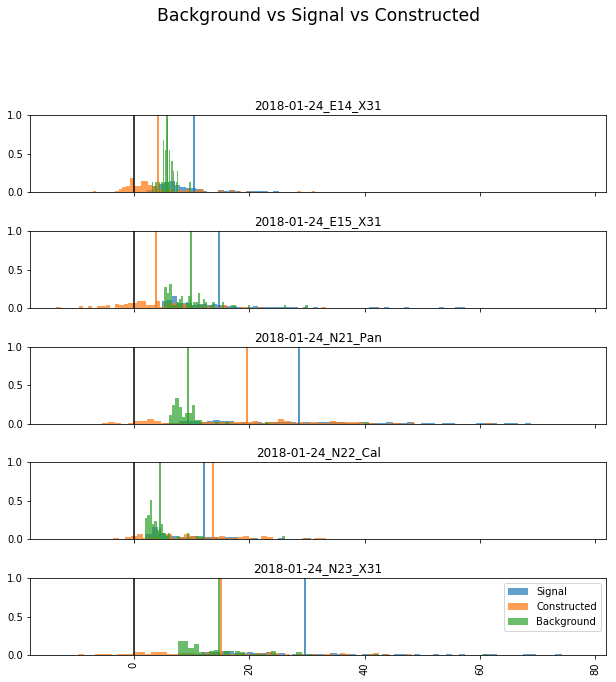

In [22]:

fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True,figsize=(10,10))
figures_data_mapping = zip(axes,mean_data.columns)
raw_data.dropna().hist(column='Intensity',bins=60,by='Collection',ax=axes, alpha=0.7, label='Signal',color=colors[0], normed=1)
constructed_data.hist(column='Intensity',bins=60,by='Collection',ax=axes, alpha=0.7, label='Constructed',normed=1,color=colors[1])
background_data.hist(column='Intensity',bins=60,by='Collection',ax=axes,alpha=0.7,label='Background',normed=1,color=colors[2])
for i in figures_data_mapping:
    i[0].axvline(x=0,color='k')

    i[0].axvline(x=mean_data[i[1]][0],color=colors[0])
    i[0].axvline(x=mean_data[i[1]][2],color=colors[1])
    i[0].axvline(x=mean_data[i[1]][1],color=colors[2])




plt.suptitle("Background vs Signal vs Constructed",  x=0.5, y=1.05, ha='center',  fontsize='xx-large')


plt.legend()
plt.show()

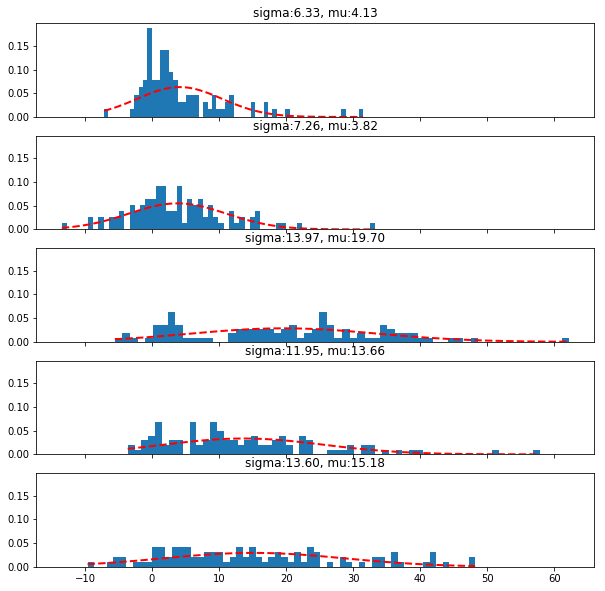

In [15]:
#fit to gaussian
from scipy.stats import norm
import matplotlib.mlab as mlab

histograms = [(plt.hist(group["Intensity"],60,normed=1)[1],norm.fit(group["Intensity"])) for name, group in constructed_data.groupby('Collection')]
gauss = [(collection[0],collection[1][0],collection[1][1], mlab.normpdf(collection[0],collection[1][0],collection[1][1])) for collection in histograms]  
plt.close()
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True,figsize=(10,10))
axes_it= iter(axes)
gauss_it = iter(gauss)
for name, group in constructed_data.groupby('Collection'):
    
    ax = next(axes_it)
    bins, mu, sigma ,y = next(gauss_it)
    
    ax.plot(bins, y, 'r--', linewidth=2)
    ax.set_title( "sigma:{:.2f}, mu:{:.2f}".format(sigma,mu))
    ax.hist(group["Intensity"],60,normed=1)
plt.show()   

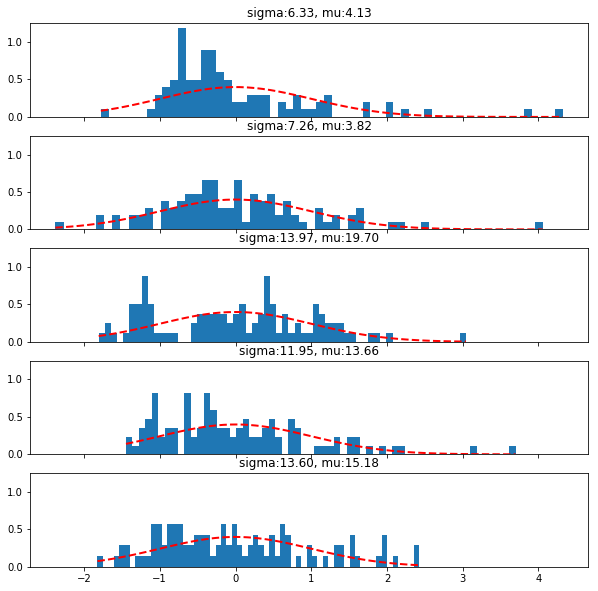

,Ligand Batch,Ligand Batch Concentration,Ligand,Analyte Batch,Analyte,Intensity,Collection,Row,Column,Block,Replica,Constructed Feature
1485,DYE100DYE025,NaN,Dye001,X31A,A/Aichi/2/68(H3N2)-X31,2.067963,2018-01-24_N23_X31,20,4,2,2,True
1486,P001-1P001-025,NaN,P001,Pan,381513,17.713433,2018-01-24_N21_Pan,30,9,3,2,True
1487,1.0_pep130.25_pep13,NaN,P016,Pan,381513,-3.316580,2018-01-24_N21_Pan,9,6,1,3,True
1488,1.0_pep500.25_pep50,NaN,pep50,Pan,381513,25.600441,2018-01-24_N21_Pan,10,8,1,3,True
1489,1.0_pep610.25_pep61,NaN,pep61,X31A,A/Aichi/2/68(H3N2)-X31,-1.655972,2018-01-24_E14_X31,32,1,3,2,True
1490,1.0_pep140.25_pep14,NaN,P017,X31A,A/Aichi/2/68(H3N2)-X31,4.164521,2018-01-24_N23_X31,3,3,1,1,True
1491,1.0_pep130.25_pep13,NaN,P016,Cal,1316510,1.263633,2018-01-24_N22_Cal,14,10,2,1,True
1492,P001-1P001-025,NaN,P001,X31A,A/Aichi/2/68(H3N2)-X31,13.532094,2018-01-24_N23_X31,10,2,1,3,True
1493,1.0_pep500.25_pep50,NaN,pep50,X31A,A/Aichi/2/68(H3N2)-X31,8.523184,2018-01-24_E15_X31,7,5,1,2,True
1494,1.0_pep490.25_pep49,NaN,pep49,Cal,1316510,18.665616,2018-01-24_N22_Cal,34,5,3,3,True


In [16]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True,figsize=(10,10))
axes_it= iter(axes)
gauss_it = iter(gauss)
normalized_data = copy.deepcopy(constructed_data)

for name, group in constructed_data.groupby('Collection'):
    
    ax = next(axes_it)
    bins, mu, sigma ,y = next(gauss_it)

    datos = (group["Intensity"]-mu)/sigma 
    normalized_data.loc[group.index]["Intensity"] = datos
    #a.hist(data)
    n, bins, patches = ax.hist(datos,60,normed=1)

    # add a 'best fit' line
    y = mlab.normpdf( bins, 0,1)
    ax.plot(bins, y, 'r--', linewidth=2)
    

    #a.plot((bins-mu)/sigma,y, 'r--', linewidth=2)
    ax.set_title( "sigma:{:.2f}, mu:{:.2f}".format(sigma,mu))

plt.show()   
normalized_data

In [19]:

data = a.Data(spots=normalized_data,reformat=False)
analysis = a.Analysis(data=data)
performance_tabels = []
for _ in range(20):
    data._safe_random_permutation(data.data, with_in="Block")
    analysis = a.Analysis(data=data)
    performance_tabels += tuple((analysis.performance_table(),))
df = pd.concat(performance_tabels,axis=0)
    

AttributeError: 'Data' object has no attribute 'data'

,unweighted accuracy,true positive,false positive,true negative,false negative,Name
0,70.333333,74.475275,25.524725,85.565982,14.434018,Nearest Neighbors
1,47.333333,64.188286,35.811714,81.138395,18.861605,Decision Tree
2,58.000000,76.327369,23.672631,83.559372,16.440628,Random Forest
3,57.666667,72.044139,27.955861,84.787168,15.212832,AdaBoost
4,72.000000,80.986722,19.013278,89.008768,10.991232,Naive Bayes
5,52.333333,61.243522,38.756478,82.247148,17.752852,LDA


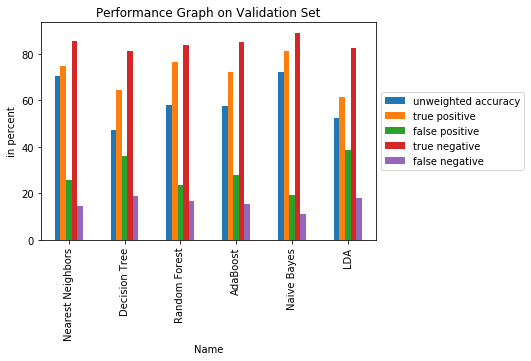

In [16]:
performace_mean = df.groupby(df.index).mean()    
performace_mean["Name"] = performance_tabels[0]["Name"]
display(performace_mean)

performace_mean.plot.bar("Name")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Performance Graph on Validation Set')
plt.ylabel('in percent')
#plt.savefig('performance_validators_on_unprocest_shuffeld_data.png',bbox_inches='tight')
plt.show()

In [17]:
data = a.Data(spots=normalized_data,mean_on="Block",reformat=False)
performance_tabels = []
for _ in range(20):
    analysis = a.Analysis(data=data)
    performance_tabels += tuple((analysis.performance_table(),))
    data._safe_random_permutation(data.data, with_in="Collection")


df = pd.concat(performance_tabels,axis=0)


[u'Analyte Batch', u'Collection', u'Block']
Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Block


/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/janekg89/Envs/flutype_webapp/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [29]:
display(df)
performace_mean = df.groupby(df.index).mean()    
performace_mean["Name"] = performance_tabels[0]["Name"]
performace_mean

,Name,unweighted accuracy,true positive,false positive,true negative,false negative
0,Nearest Neighbors,60.0,60.000000,40.000000,80.000000,20.000000
1,Decision Tree,60.0,100.000000,0.000000,83.333333,16.666667
2,Random Forest,60.0,75.000000,25.000000,81.818182,18.181818
3,AdaBoost,60.0,100.000000,0.000000,83.333333,16.666667
4,Naive Bayes,40.0,66.666667,33.333333,75.000000,25.000000
5,LDA,80.0,80.000000,20.000000,90.000000,10.000000
0,Nearest Neighbors,80.0,80.000000,20.000000,90.000000,10.000000
1,Decision Tree,40.0,60.000000,40.000000,80.000000,20.000000
2,Random Forest,60.0,75.000000,25.000000,81.818182,18.181818
3,AdaBoost,80.0,66.666667,33.333333,88.888889,11.111111


,unweighted accuracy,true positive,false positive,true negative,false negative,Name
0,75.0,78.750000,21.250000,87.727273,12.272727,Nearest Neighbors
1,53.0,73.154762,26.845238,84.981061,15.018939,Decision Tree
2,52.0,73.000000,27.000000,78.889277,21.110723,Random Forest
3,54.0,70.178571,29.821429,83.566919,16.433081,AdaBoost
4,54.0,74.916667,25.083333,79.732517,20.267483,Naive Bayes
5,62.0,66.363095,33.636905,86.392677,13.607323,LDA


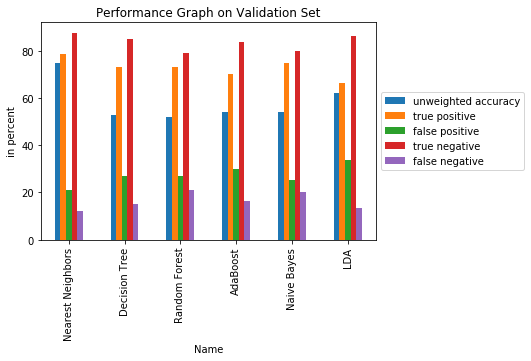

In [19]:
performace_mean.plot.bar("Name")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Performance Graph on Validation Set')
plt.ylabel('in percent')
#plt.savefig('performance_validators_on_unprocest_shuffeld_data.png',bbox_inches='tight')
plt.show()

In [45]:

normalized_data_only_3D_NHS = normalized_data[normalized_data.Collection != "2018-01-24_E14_X31"]
normalized_data_only_3D_NHS = normalized_data_only_3D_NHS[normalized_data_only_3D_NHS.Collection != "2018-01-24_E15_X31"]

                       
data = a.Data(spots=normalized_data_only_3D_NHS,reformat=False)

## delete bad peptides:
#test_data = test_data[test_data.Ligand != 'P016']
#test_data = test_data[test_data.Ligand != 'Dye001']
#test_data = test_data[test_data.Ligand != 'pep61']

[u'Analyte Batch', u'Collection', u'Block', u'Replica']


In [46]:
print(len(normalized_data))
print(len(normalized_data_only_3D_NHS))

495
297


In [47]:
performance_tabels = []
for _ in range(20):
    analysis = a.Analysis(data=data)
    performance_tabels += tuple((analysis.performance_table(),))
    data._safe_random_permutation(data.data, with_in="Block")


df = pd.concat(performance_tabels,axis=0)

Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica


In [48]:
performace_mean = df.groupby(df.index).mean()    
performace_mean["Name"] = performance_tabels[0]["Name"]
performace_mean

,unweighted accuracy,true positive,false positive,true negative,false negative,Name
0,52.777778,55.724206,44.275794,76.836257,23.163743,Nearest Neighbors
1,30.000000,51.735764,48.264236,76.862340,23.137660,Decision Tree
2,48.888889,69.900794,30.099206,78.968789,21.031211,Random Forest
3,37.222222,54.649378,45.350622,78.871940,21.128060,AdaBoost
4,53.333333,70.134380,29.865620,82.886533,17.113467,Naive Bayes
5,34.444444,48.236833,51.763167,75.723921,24.276079,LDA


In [52]:
data = a.Data(spots=normalized_data_only_3D_NHS,reformat=False)


[u'Analyte Batch', u'Collection', u'Block', u'Replica']


In [53]:
len(data.data)

27

In [57]:
normalized_data_only_3D_NHS
## delete bad peptides:
n_data_only_3D_NHS_pep_select = normalized_data_only_3D_NHS[normalized_data_only_3D_NHS.Ligand != 'P016']
n_data_only_3D_NHS_pep_select = n_data_only_3D_NHS_pep_select[n_data_only_3D_NHS_pep_select.Ligand != 'Dye001']
n_data_only_3D_NHS_pep_select = n_data_only_3D_NHS_pep_select[n_data_only_3D_NHS_pep_select.Ligand !='pep61']
data = a.Data(spots=n_data_only_3D_NHS_pep_select,reformat=False)
len(n_data_only_3D_NHS_pep_select)


[u'Analyte Batch', u'Collection', u'Block', u'Replica']


216

In [58]:
performance_tabels = []
for _ in range(20):
    analysis = a.Analysis(data=data)
    performance_tabels += tuple((analysis.performance_table(),))
    data._safe_random_permutation(data.data, with_in="Block")


df = pd.concat(performance_tabels,axis=0)

Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica
Replica


In [59]:
performace_mean = df.groupby(df.index).mean()    
performace_mean["Name"] = performance_tabels[0]["Name"]
performace_mean

,unweighted accuracy,true positive,false positive,true negative,false negative,Name
0,56.111111,63.382937,36.617063,79.227652,20.772348,Nearest Neighbors
1,36.666667,57.027958,42.972042,78.323830,21.676170,Decision Tree
2,41.666667,75.166667,24.833333,76.521334,23.478666,Random Forest
3,46.111111,62.103175,37.896825,79.403282,20.596718,AdaBoost
4,52.222222,68.396465,31.603535,82.626655,17.373345,Naive Bayes
5,49.444444,58.266234,41.733766,80.489358,19.510642,LDA
